<a href="https://colab.research.google.com/github/thaianh1210/FinancialSentimentAnalysis/blob/main/FinancialSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk


nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import zipfile
with zipfile.ZipFile('/content/financial_sentiment.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [ ]:
dataset_path = '/content/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(dataset_path, names = headers, encoding = 'ISO-8859-1')
df

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
classes = {
    class_name: idx for idx , class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df['sentiment']

0       0
1       0
2       1
3       2
4       2
       ..
4841    1
4842    0
4843    1
4844    1
4845    1
Name: sentiment, Length: 4846, dtype: int64

In [ ]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
  text = text.lower()
  text = text.strip()
  text = re.sub(r'[^\w\s]','', text)
  text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
  return text

In [ ]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))
df['content']

0       accord gran  compani plan move product russia ...
1       technopoli plan develop stage area less 100000...
2       intern electron industri compani elcoteq laid ...
3       new product plant compani would increas capac ...
4       accord compani updat strategi year 20092012  b...
                              ...                        
4841    london marketwatch  share price end lower lond...
4842    rinkuskiai beer sale fell 65 per cent 416 mill...
4843    oper profit fell eur 354 mn eur 688 mn 2007  i...
4844    net sale paper segment decreas eur 2216 mn sec...
4845    sale finland decreas 105  januari  sale outsid...
Name: content, Length: 4846, dtype: object

In [ ]:
vocab = []
for sentence in df['content'].tolist():
  tokens = sentence.split()
  for token in tokens:
    if token not in vocab:
      vocab.append(token)
vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [ ]:
def transform(text, word_to_idx, max_seq_len):
  tokens = []
  for w in text.split():
    try:
      w_ids = word_to_idx[w]
    except:
      w_ids = word_to_idx['UNK']
    tokens.append(w_ids)
  if len(tokens) < max_seq_len:
    tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
  elif len(tokens) > max_seq_len:
    tokens = tokens[:max_seq_len]
  return tokens

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size = val_size,
    random_state = seed,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels,
    test_size = test_size,
    random_state = seed,
    shuffle = is_shuffle
)

In [ ]:
class FinancialNews(Dataset):
  def __init__(
      self,
      X, y,
      word_to_idx,
      max_seq_len,
      transform = None
  ):
    self.texts = X
    self.labels = y
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]

    if self.transform:
      text = self.transform(
          text,
          self.word_to_idx,
          self.max_seq_len
      )
    text = torch.tensor(text)

    return text, label

In [ ]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx = word_to_idx,
    max_seq_len = max_seq_len,
    transform = transform
)

val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx = word_to_idx,
    max_seq_len = max_seq_len,
    transform = transform
)

test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx = word_to_idx,
    max_seq_len = max_seq_len,
    transform = transform
)

In [ ]:
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = is_shuffle
)

val_loader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = test_batch_size,
    shuffle = False
)


In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(
      self, vocab_size, embedding_dim,
      hidden_size, n_layers, n_classes,
      dropout_prob):
    super(SentimentClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first = True, bidirectional = False)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_size, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x


In [ ]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    hidden_size = hidden_size,
    n_layers = n_layers,
    n_classes = n_classes,
    dropout_prob = dropout_prob
).to(device)

In [ ]:
lr = 1e-4
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = lr
    )

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs):
  train_losses = []
  val_losses =[]
  train_accuracies = []
  val_accuracies = []

  for epoch in range(epochs):
    batch_train_losses = []
    batch_train_accuracies = []
    model.train()
    total = 0
    correct = 0
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)
    acc = correct / total
    train_accuracies.append(acc)
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'EPOCH {epoch + 1}:\tTrain loss : {train_loss :.4f}\tVal loss : {val_loss :.4f}')
    print(f'EPOCH {epoch + 1}:\tTrain accuracies : {acc :.4f}\tVal accuracies : {val_acc :.4f}')
  return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  accuracies = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  loss = sum(losses) / len(losses)
  acc = correct / total
  return loss, acc



In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = fit(
    model, train_loader, val_loader, criterion, optimizer, device, epochs
)

EPOCH 1:	Train loss : 1.0408	Val loss : 0.9940
EPOCH 1:	Train accuracies : 0.5231	Val accuracies : 0.5866
EPOCH 2:	Train loss : 0.9761	Val loss : 0.9561
EPOCH 2:	Train accuracies : 0.5939	Val accuracies : 0.5866
EPOCH 3:	Train loss : 0.9417	Val loss : 0.9299
EPOCH 3:	Train accuracies : 0.5950	Val accuracies : 0.5866
EPOCH 4:	Train loss : 0.9297	Val loss : 0.9298
EPOCH 4:	Train accuracies : 0.5950	Val accuracies : 0.5866
EPOCH 5:	Train loss : 0.9297	Val loss : 0.9290
EPOCH 5:	Train accuracies : 0.5955	Val accuracies : 0.5866
EPOCH 6:	Train loss : 0.9353	Val loss : 0.9292
EPOCH 6:	Train accuracies : 0.5948	Val accuracies : 0.5866
EPOCH 7:	Train loss : 0.9266	Val loss : 0.9289
EPOCH 7:	Train accuracies : 0.5950	Val accuracies : 0.5866
EPOCH 8:	Train loss : 0.9294	Val loss : 0.9290
EPOCH 8:	Train accuracies : 0.5953	Val accuracies : 0.5866
EPOCH 9:	Train loss : 0.9305	Val loss : 0.9288
EPOCH 9:	Train accuracies : 0.5953	Val accuracies : 0.5866
EPOCH 10:	Train loss : 0.9310	Val loss : 0.928

In [ ]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
  epochs = list(range(num_epochs))
  fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
  axs[0].plot(epochs, train_accs, label = "Training")
  axs[0].plot(epochs, eval_accs, label = "Evaluation")
  axs[1].plot(epochs, train_losses, label = "Training")
  axs[1].plot(epochs, eval_losses, label = "Evaluation")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Accuracy")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Loss")
  plt.legend()

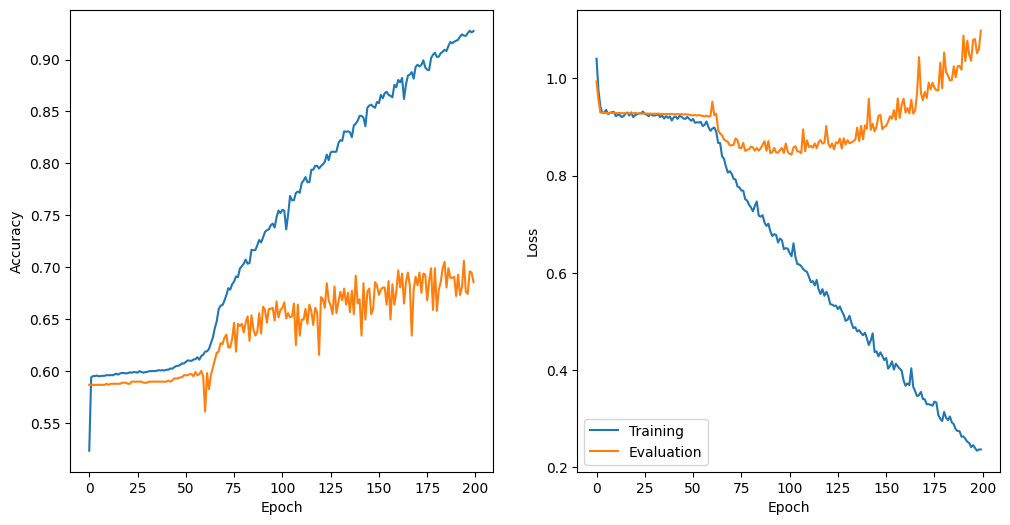

In [ ]:

plot = plot_result(epochs, train_accuracies, val_accuracies, train_losses, val_losses)
plot